In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math

/Library/Python/2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def assign_genotype_attr(tree, mrcas):
    ''' Finds the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items() if key!='genotype' and k!='clade_name'}
        
    for genotype, node in mrcas.items():
        node.traits['genotype_mrca'] = True
        node.traits['genotype'] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if 'genotype' in child.traits:
                if genotype != child.traits['genotype']:
                    print 'ERROR: Overlapping genotypes %s and %s at index %s'%(child.traits['genotype'], genotype, child.index)
            child.traits['genotype'] = genotype
    return tree

def load_tree_find_mrcas(path = '/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_all_tree.json'):    
    tree = bt.loadJSON(path) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node for node in tree.Objects if 'clade_name' in node.traits
            and node.traits['clade_name'] != 'DENV2_AMERICAN'}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas}

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    clades = sorted(list(genotypes)) # ['asianI', 'american', ...]
    cm_subsection = linspace(0, 1, len(clades)) # [0, 0.2, 0.4, ...]
    colors = [ cm.viridis(x) for x in cm_subsection ] # [viridis[0], viridis[0.2], ...]
    cmap = { clade: color for (clade, color) in zip(clades, colors)} # {'asianI': viridis[0], ...}
    return cmap

def load_frequencies(mrcas, path='/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_all_frequencies.json'):
    '''
    {'frequencies': 
        {'south_america': 
            {'denv2_american': [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)
    }
    '''    
    all_frequencies = json.load(open(path, 'r'))
    pivots =  all_frequencies.pop('pivots') # [1917., 1918., ...]
        
#     mrca_idx = { mrca.index: genotype for genotype, mrca in mrcas.items()}

    ### This is a hacky trick to find the frequency vectors that pair with the genotype mrcas.
    ### Should change this to use the mrca_idx from the tree index --> frequencies vector. 
    ### This way I can later adjust exactly where the genotype MRCA has been assigned based on the tree 
    ### and pull the corresponding frequencies vector.
    
    named_clade_frequencies = { clade : freqs
                               for clade,freqs in all_frequencies.items()
                              if 'clade' not in clade} ## {'global:denv2_asianI':[0.1, 0.23, ...]}
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'denv2_asianI': [0.1, 0.23, ...] } }
    for label, freqs in named_clade_frequencies.items():
            label = label.split('_') # 'global:denv2_asianI' --> ['denv2', 'asianI']
            region, genotype = '_'.join(label[:-2]), '_'.join(label[-2:])
            regional_clade_frequencies[region][genotype] = freqs 
            genotypes.append(genotype)
    return {'frequencies': regional_clade_frequencies, 
            'pivots': pivots }

In [3]:
tmp = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = tmp['tree']

# {'DENV2_AMERICAN': <baltic node>}
mrcas = tmp['mrcas']


# ['denv2/american', 'denv1/I', ...]
genotypes = mrcas.keys()

tmp = load_frequencies(mrcas)
# {'south_america': 
#         {'denv2_american': [ (1900, 0.2), (1920, 0.26), ....]},
#     }                      
frequencies = tmp['frequencies']

# ['south_america', 'southeast_asia']
regions = frequencies.keys()

# [1917., 1918., ...]
pivots = tmp['pivots']

# {'denv2/american': color}
colors = assign_genotype_colors(genotypes)


Tree height: 404.784340
Tree length: 8947.442480
annotations present

Numbers of objects in tree: 1611 (775 nodes and 836 leaves)



In [4]:
def plot_region_frequencies(region, frequencies=frequencies, pivots=pivots):
    plt.title(region)
    plt.xlabel('Year')
    plt.ylabel('Genotype Frequency')
    for genotype, freqs in frequencies[region].items():
        plt.plot(pivots, freqs, color=colors[genotype], label=genotype)
        
def plot_tree():
    branchWidth=2 ## default branch width
    ll = tree
    xmax = max([k.absoluteTime for k in ll.Objects]) + 0.25

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = colors[k.traits['genotype']] if k.traits.has_key('genotype') else 'gray'

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight

            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            if 'genotype_mrca' in k.traits:
                plt.text(xmax, y, k.traits['genotype'], zorder=100)
                plt.text(x,y, k.index, ha='right', zorder=100)
                plt.text(k.parent.absoluteTime, k.parent.y, k.parent.index, ha='right')
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))


def plot_frequencies_and_tree():
    sns.set(style='whitegrid', font_scale = 1.3)
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(2,3, width_ratios=[1,1,3], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_frequencies('global')
    plt.legend(loc=(2.5,-0.1), title="Dengue Genotypes", fontsize='large')
    globe.set_ylim([0, 1])

    south_america = plt.subplot(gs[1,0])
    plot_region_frequencies('south_america')
    south_america.set_ylim([0, 1])
    
    southeast_asia = plt.subplot(gs[1,1])
    plot_region_frequencies('southeast_asia')
    southeast_asia.set_ylim([0, 1])
        
    sns.set(style = 'white', font_scale = 1.3)
    treeplot = plt.subplot(gs[:,-1])
    plot_tree()
        
    plt.tight_layout()
    plt.show()

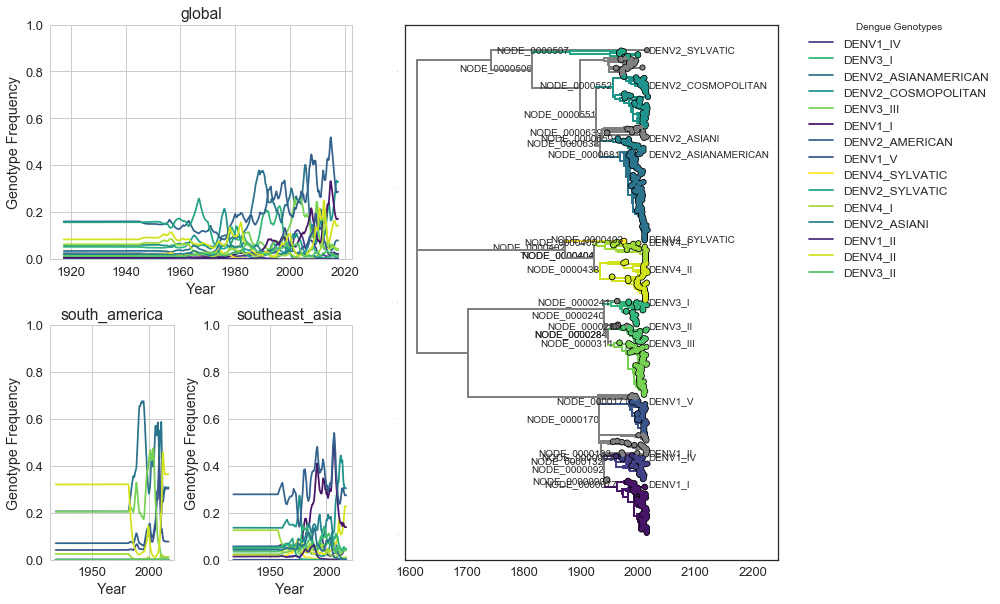

In [5]:
plot_frequencies_and_tree()

In [6]:
def make_dataframe(region, mindate = 1970):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    region_data = frequencies[region]
    df = pd.DataFrame(region_data, index=pivots)
    df = df.loc[df.index[df.index >= mindate]]
    return df

In [7]:
region_dfs = {}
for region in regions:
    region_dfs[region] = make_dataframe(region)
#     {'south_america': pd.DataFrame(columns=genotypes, index=pivots, values=frequencies) }

In [8]:
print region_dfs['southeast_asia'].head()

           DENV1_I  DENV1_II  DENV1_IV  DENV1_V  DENV2_AMERICAN  \
1970.0000   0.0558    0.0137    0.0154        0          0.2764   
1970.0833   0.0563    0.0138    0.0155        0          0.2789   
1970.1667   0.0568    0.0139    0.0156        0          0.2813   
1970.2500   0.0572    0.0140    0.0158        0          0.2835   
1970.3333   0.0577    0.0141    0.0159        0          0.2856   

           DENV2_ASIANAMERICAN  DENV2_ASIANI  DENV2_COSMOPOLITAN  \
1970.0000               0.0470        0.0620              0.1508   
1970.0833               0.0469        0.0619              0.1506   
1970.1667               0.0469        0.0618              0.1504   
1970.2500               0.0468        0.0617              0.1501   
1970.3333               0.0467        0.0616              0.1498   

           DENV2_SYLVATIC  DENV3_I  DENV3_II  DENV3_III  DENV4_I  DENV4_II  \
1970.0000          0.0908   0.0564    0.0556     0.0377   0.0349    0.0334   
1970.0833          0.0880   0.05

In [8]:
def define_seasons(pivots, mindate=1970):
    '''Returns tuples of numdates for 
    May - December dengue seasons for each year in pivots'''
    min_year = mindate if mindate else int(math.floor(min(pivots)))
    max_year = int(math.ceil(max(pivots)))
    seasons = [(year + 5./12., year + 364./365.) 
               for year in range(min_year, max_year)]
    return seasons #[(start, end), (start, end)]


def find_hyperendemic_seasons(seasons, region):
    '''
    Return a subset of the data from seasons where there were >= 2 genotypes 
    circulating in the region
    '''
    
    def bin_seasons(numdate):
        ''' Return (start, end) season numdate belongs in'''
        season = np.nan
        for start, end in seasons:
            if numdate >= start and numdate<= end:
                season = (start, end)
                break
        return season

    def is_hyperendemic(subset):
        ''' Return boolean of whether there were >2 genotypes 
        at >= 5% frequency on average during that season'''
        mean_frequencies = subset.mean()
        above_five_percent = mean_frequencies[mean_frequencies >= 0.05]
        return len(above_five_percent) >= 2 ## return boolean
        print above_five_percent
    
    df = region_dfs[region]
    these_pivots = df.index
    df['season'] = these_pivots.map(bin_seasons)
    
    hyperendemic_seasons = []
    
    for season in seasons:
        if is_hyperendemic(df.loc[df['season'] == season]):
            hyperendemic_seasons.append(season)
    
    hyperendemic_frequencies = df.loc[df['season'].isin(hyperendemic_seasons)]
    return hyperendemic_frequencies

In [9]:
seasons = define_seasons(pivots)

hyperendemic_frequencies = {}
for region in regions:
    hyperendemic_frequencies[region] = find_hyperendemic_seasons(seasons, region)

In [10]:
def are_intraserotype(genotype1, genotype2):
    return genotype1.split('_')[0] == genotype2.split('_')[0]

def intra_inter_serotype_pairs(freqs, min_frequency = 0.05):
    ''' Takes row from genotype frequencies dataframe,
    finds all genotypes above min_frequency at this time point, 
    returns proportion of all pairs of cocirculating genotypes that are from the same serotype'''
    above_min_frequency = freqs[freqs >= 0.05]
    cocirculating_genotypes = above_min_frequency.index.values
    pairs = [i for i in combinations(cocirculating_genotypes, 2)]
    
    n_intraserotype_pairs = 0.
    for genotype1, genotype2 in pairs:
        if are_intraserotype(genotype1, genotype2):
            n_intraserotype_pairs += 1.
            
    total_pairs = float(len(pairs))
    return n_intraserotype_pairs / total_pairs

def map_intra_inter_serotype_pairs(df):
    proportion_intraserotype = df.apply(intra_inter_serotype_pairs, axis=1)
    mean_proportion_intraserotype = proportion_intraserotype.mean()
    return mean_proportion_intraserotype

def shuffle_labels(df):
    shuffled = df.copy()
    np.random.shuffle(shuffled.columns.values)
    return shuffled

In [14]:
def cocirculating(region, n = 1000):
    data = hyperendemic_frequencies[region].groupby('season').agg('mean')

    c = map_intra_inter_serotype_pairs(data)

    null_distribution = []
    for i in range(n):
        shuffled_data = shuffle_labels(data)
        null_distribution.append(map_intra_inter_serotype_pairs(shuffled_data))
    
    return {'c': c, 'null_distribution': null_distribution}

In [15]:
# cocirculating_in_south_america = cocirculating('south_america')

cocirculating_in_southeast_asia = cocirculating('southeast_asia')
c = cocirculating_in_southeast_asia['c']
null = cocirculating_in_southeast_asia['null_distribution']

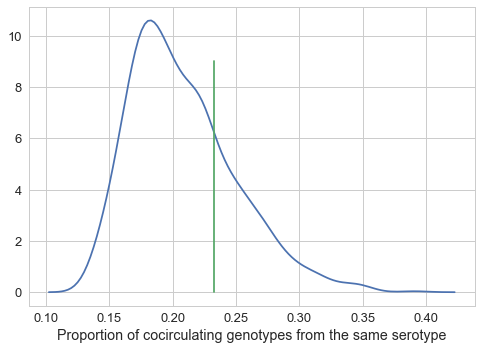

In [16]:
sns.set_style('whitegrid')
cocirculating_plot = sns.kdeplot(pd.Series(null))
cocirculating_plot.plot([c for i in range(10)], [i for i in range(10)])
cocirculating_plot.set_xlabel('Proportion of cocirculating genotypes from the same serotype')